In [1]:
import json
from pathlib import Path

import pandas as pd

from protrend.utils import Settings

report_file_path = Path(Settings.report_working_directory).joinpath('protrend_report_2022_09_01_10_22_14.json')
with open(report_file_path, 'r') as f:
    report = json.load(f)

df = pd.DataFrame(list(report.values()))
df

,source,version,system,label,objects,properties,source_label,target_label,relationships
0,collectf,0.0.1,transform,evidence,56.0,5.0,NaN,NaN,NaN
1,collectf,0.0.1,integrate,evidence,56.0,9.0,NaN,NaN,NaN
2,collectf,0.0.1,extract,organism,153.0,7.0,NaN,NaN,NaN
3,collectf,0.0.1,transform,organism,155.0,14.0,NaN,NaN,NaN
4,collectf,0.0.1,integrate,organism,153.0,19.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
373,standardizer,0.0.0,integrate,regulatoryinteraction,111.0,1.0,NaN,NaN,NaN
374,standardizer,0.0.0,transform,evidence,104.0,1.0,NaN,NaN,NaN
375,standardizer,0.0.0,integrate,evidence,104.0,1.0,NaN,NaN,NaN
376,standardizer,0.0.0,transform,publication,16230.0,1.0,NaN,NaN,NaN


In [2]:
data = df[(df.source == 'standardizer') & (df.system == 'transform')]
data = data[['label', 'objects']].reset_index(drop=True)
data = data.set_index('label')
data = data.to_dict(orient='dict')
data = {key: [val] for key, val in data['objects'].items()}
data

{'organism': [90.0],
 'regulator': [172.0],
 'source': [1.0],
 'gene': [3483.0],
 'regulatoryfamily': [47.0],
 'effector': [95.0],
 'operon': [0.0],
 'tfbs': [3154.0],
 'pathway': [11.0],
 'regulatoryinteraction': [111.0],
 'evidence': [104.0],
 'publication': [16230.0]}

In [3]:
from protrend.utils import NeoDatabase, Settings
from protrend.model import *

# connect to database
neo_db = NeoDatabase(user_name=Settings.db_user_name, password=Settings.db_password,
                     ip=Settings.db_ip, port=Settings.db_port)
neo_db.connect()

In [4]:
nodes = (
    Effector,
    Evidence,
    Gene,
    Operon,
    Organism,
    Pathway,
    Publication,
    Regulator,
    RegulatoryFamily,
    RegulatoryInteraction,
    Source,
    TFBS,
)

for node in nodes:
    data[node.node_name()].append(len(node.nodes))

data

{'organism': [90.0, 526],
 'regulator': [172.0, 12301],
 'source': [1.0, 11],
 'gene': [3483.0, 99517],
 'regulatoryfamily': [47.0, 156],
 'effector': [95.0, 406],
 'operon': [0.0, 22905],
 'tfbs': [3154.0, 73950],
 'pathway': [11.0, 276],
 'regulatoryinteraction': [111.0, 195583],
 'evidence': [104.0, 78],
 'publication': [16230.0, 2192]}

In [5]:
df = pd.DataFrame(data)
df = df.transpose()
df = df.drop(index=['regulatoryinteraction', 'operon', 'source'])
df = df.rename(columns={1: 'standardized', 0: 'no standardization'})
df['no standardization'] = df['standardized'] + df['no standardization']
df['relative frequency of standardization'] = df['standardized'] / df['no standardization']
df = df.sort_values(by='relative frequency of standardization')
df

,no standardization,standardized,relative frequency of standardization
publication,18422.0,2192.0,0.118988
evidence,182.0,78.0,0.428571
regulatoryfamily,203.0,156.0,0.768473
effector,501.0,406.0,0.810379
organism,616.0,526.0,0.853896
tfbs,77104.0,73950.0,0.959094
pathway,287.0,276.0,0.961672
gene,103000.0,99517.0,0.966184
regulator,12473.0,12301.0,0.986210


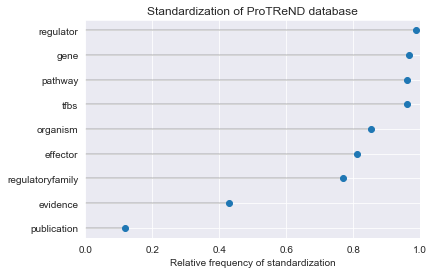

In [6]:
from matplotlib import pyplot as plt

y = range(1,len(df.index)+1)

# The horizontal plot is made using the hline function
plt.hlines(y=y, xmin=0, xmax=df['relative frequency of standardization'],
           color='grey', alpha=0.4)
# plt.scatter(df['standardized'], y, color='skyblue', alpha=1, label='standardized')
# plt.scatter(df['no standardization'], y, color='green', alpha=0.4 , label='no standardization')
# plt.legend()
plt.plot(df['relative frequency of standardization'], y, "o")

plt.xlim(0,1)

# Add title and axis names
plt.yticks(y, df.index)
plt.title("Standardization of ProTReND database")
plt.xlabel('Relative frequency of standardization')

# Show the graph
plt.savefig("standardization_report.png", bbox_inches="tight", dpi=150)
plt.show()